In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

mean = (0.5, 0.5, 0.5)
std =  (0.5, 0.5, 0.5)
batch_size = 128
optim_type = 'SGD'
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
]) 

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [12]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = False
        if stride == 1 and in_channels == out_channels:
            self.shortcut = True


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut == True:
            out += x
        out = F.relu(out)
        return out

In [13]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        # stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16) 
        # output: channel=16, size=32x32
        self.conv2 = nn.Sequential(
            # torch.nn.MaxPool2d(kernel_size, stride=None, padding=0,
            # dilation=1, return_indices=False, ceil_mode=False)
            BasicBlock(16, 16, 1),
            BasicBlock(16, 16, 1),
            BasicBlock(16, 16, 1)
            # output: channel=32, size=32x32
        )
        self.conv3 = nn.Sequential(
            BasicBlock(16, 32, 2),
            BasicBlock(32, 32, 1),
            BasicBlock(32, 32, 1)
            # output: channel=32, size=16x16
        )
        self.conv4 = nn.Sequential(
            BasicBlock(32, 64, 2),
            BasicBlock(64, 64, 1),
            BasicBlock(64, 64, 1)
            # output: channel=64, size=8x8
        )
        # torch.nn.AvgPool2d(kernel_size, stride=None, padding=0, 
        # ceil_mode=False, count_include_pad=True)
        self.pool = nn.AvgPool2d(8)
        # output: channel=512, size=1x1
        self.linear = nn.Linear(64, 10)
        # output: channel=10, size=1x1

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [20]:
x = Variable(torch.randn(128, 3, 32, 32))
net = ResNet()
y = net(x)
print(x.size(),y.size())

torch.Size([128, 3, 32, 32]) torch.Size([128, 10])


In [21]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
# Training
criterion = nn.CrossEntropyLoss()
# torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
train_loss=[]
print('Start training')
for epoch in range(10):
    # running_loss = 0.0
    # acc_count = 0
    # total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # running_loss += loss.data[0]
        
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels.data).sum()
        # acc_count += c
        # total += labels.size(0)
        num = i+len(trainloader)*epoch
        
        writer.add_scalar('Train/Loss', loss.data[0], num)
        writer.add_scalar('Train/Accuracy', c/labels.size(0), num)
        
        print(num, c, loss.data[0])
    print('epoch %2d training done!'% (epoch+1))
    running_loss = 0.0
    acc_count = 0
    total = 0
    count = 0
    print('calculate testing loss/accuracy...')
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs, volatile=True), Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels.data).sum()
        acc_count += c
        total += labels.size(0)
        count += 1
        print(i, c, loss.data[0])
    writer.add_scalar('Test/Loss', running_loss/count, epoch+1)
    writer.add_scalar('Test/Accuracy',acc_count/total, epoch+1)
    print('epoch %d done'% (epoch+1))
        
writer.close()
print('Finish Training')


Start training
0 11 2.436166763305664
1 11 2.3739984035491943
2 14 2.301891565322876
3 16 2.3796133995056152
4 19 2.302546262741089
5 22 2.2776503562927246
6 20 2.2390100955963135
7 17 2.290945529937744
8 21 2.1884353160858154
9 18 2.169166088104248
10 33 2.0902180671691895
11 34 2.0890400409698486
12 31 2.0579721927642822
13 24 2.0794222354888916
14 20 2.0267930030822754
15 32 2.0426597595214844
16 34 2.016779661178589
17 25 2.088893175125122
18 28 2.00445818901062
19 29 2.028555393218994
20 35 1.9901177883148193
21 23 1.9801424741744995
22 17 1.9979652166366577
23 36 2.0415985584259033
24 34 1.9314128160476685
25 27 1.9688385725021362
26 33 1.9129364490509033
27 27 1.9489961862564087
28 31 1.9307141304016113
29 30 1.877586007118225
30 41 1.9104113578796387
31 33 1.90733802318573
32 28 1.989565134048462
33 41 1.9247379302978516
34 39 1.8725491762161255
35 32 1.9097405672073364
36 26 1.9707293510437012
37 35 1.914695143699646
38 35 1.8743793964385986
39 38 1.9387158155441284
40 30 1.91

323 70 1.1954991817474365
324 67 1.2538881301879883
325 62 1.376835823059082
326 62 1.312660813331604
327 64 1.3866676092147827
328 69 1.3666659593582153
329 56 1.3254635334014893
330 69 1.240827202796936
331 70 1.2435526847839355
332 67 1.2622565031051636
333 63 1.3139240741729736
334 65 1.312894582748413
335 71 1.273573875427246
336 62 1.3855972290039062
337 79 1.1699200868606567
338 75 1.3834474086761475
339 64 1.3170512914657593
340 63 1.3282792568206787
341 73 1.3552472591400146
342 66 1.2601513862609863
343 66 1.3810330629348755
344 67 1.3258576393127441
345 63 1.375626564025879
346 69 1.240052342414856
347 65 1.3607697486877441
348 62 1.4346874952316284
349 75 1.1842879056930542
350 60 1.556838870048523
351 64 1.3249073028564453
352 66 1.3116223812103271
353 62 1.4235358238220215
354 66 1.2871990203857422
355 73 1.1613080501556396
356 74 1.2866120338439941
357 76 1.2486183643341064
358 73 1.2757543325424194
359 61 1.344685435295105
360 65 1.17999267578125
361 70 1.24932909011840

563 73 1.1625940799713135
564 70 1.3204213380813599
565 77 1.0183453559875488
566 82 0.9471043348312378
567 72 1.038271188735962
568 82 0.9463091492652893
569 84 1.0283225774765015
570 78 1.0955321788787842
571 78 1.0370523929595947
572 81 1.019522786140442
573 81 1.0433282852172852
574 83 1.0902951955795288
575 78 1.0850852727890015
576 75 1.1162358522415161
577 82 0.9887455701828003
578 74 1.119968056678772
579 78 1.1210857629776
580 73 1.1453020572662354
581 92 0.8610694408416748
582 79 0.9404638409614563
583 75 1.1441576480865479
584 71 1.1639409065246582
585 80 1.1284265518188477
586 77 1.1862999200820923
587 75 1.1786136627197266
588 79 0.9460294246673584
589 75 1.1316020488739014
590 84 0.9651278257369995
591 82 1.0068752765655518
592 80 1.059198260307312
593 81 1.062919020652771
594 79 1.1683403253555298
595 78 1.123165488243103
596 87 0.9791358113288879
597 78 1.0361651182174683
598 76 1.2072830200195312
599 73 1.113153100013733
600 76 0.9887561202049255
601 84 0.8902129530906

803 80 1.0013339519500732
804 84 0.9460793137550354
805 81 0.9989454746246338
806 82 0.9505255222320557
807 87 0.863202691078186
808 90 0.8594891428947449
809 86 0.9099161624908447
810 87 0.8899160027503967
811 83 1.0285484790802002
812 93 0.7718361020088196
813 83 0.9518550634384155
814 87 0.8379754424095154
815 89 0.8561326265335083
816 84 0.9586822390556335
817 77 0.9996457695960999
818 86 0.958792507648468
819 88 0.9085628986358643
820 82 1.07932448387146
821 84 0.9084320068359375
822 82 1.0100138187408447
823 78 1.0178250074386597
824 84 0.899515688419342
825 87 0.8865115642547607
826 88 0.9188546538352966
827 82 0.9998343586921692
828 85 0.9206104278564453
829 90 0.89443039894104
830 78 1.0002530813217163
831 76 0.9470395445823669
832 78 1.1464157104492188
833 88 0.9532848596572876
834 82 1.0226269960403442
835 89 0.8789279460906982
836 87 0.8997918367385864
837 90 0.9359435439109802
838 84 0.9252507090568542
839 89 0.9396890997886658
840 82 0.9618549942970276
841 89 0.9162438511

1115 92 0.7239142060279846
1116 98 0.7201566100120544
1117 89 0.9772078990936279
1118 89 0.8619011044502258
1119 87 0.7920555472373962
1120 92 0.7807123064994812
1121 80 0.9505086541175842
1122 94 0.727834165096283
1123 88 0.8498098850250244
1124 97 0.7804126143455505
1125 93 0.7549792528152466
1126 80 1.0045459270477295
1127 88 0.8349078893661499
1128 92 0.7552478909492493
1129 85 1.016823649406433
1130 91 0.7360004782676697
1131 85 0.8179634809494019
1132 87 0.8648845553398132
1133 85 0.8958091139793396
1134 93 0.8693981766700745
1135 87 0.8420509099960327
1136 86 0.9016006588935852
1137 95 0.7914916276931763
1138 90 0.8701967597007751
1139 91 0.7120741605758667
1140 88 0.8265336751937866
1141 101 0.6535589098930359
1142 80 0.9114792346954346
1143 86 0.9232672452926636
1144 77 0.9673143029212952
1145 91 0.7929103970527649
1146 89 0.9241666793823242
1147 94 0.8354262709617615
1148 88 0.8214365243911743
1149 90 0.8696942329406738
1150 88 0.8667367696762085
1151 97 0.7395312190055847
11

1344 92 0.7646312117576599
1345 96 0.6765539050102234
1346 99 0.7237086296081543
1347 92 0.7275498509407043
1348 93 0.8882299661636353
1349 94 0.8225127458572388
1350 92 0.9372798800468445
1351 85 0.9565114378929138
1352 93 0.6878646016120911
1353 97 0.7543091177940369
1354 91 0.7724024653434753
1355 98 0.7238463163375854
1356 86 0.9563883543014526
1357 97 0.6910234093666077
1358 89 0.8120431303977966
1359 87 0.8276663422584534
1360 95 0.7434502840042114
1361 98 0.7720761299133301
1362 96 0.8144881129264832
1363 90 0.8932888507843018
1364 92 0.7977520823478699
1365 88 0.7495905756950378
1366 94 0.823932945728302
1367 98 0.6703126430511475
1368 76 0.981675386428833
1369 95 0.7705451250076294
1370 100 0.6512378454208374
1371 91 0.8451258540153503
1372 98 0.6928262710571289
1373 90 0.8647374510765076
1374 92 0.7334485650062561
1375 98 0.7282199859619141
1376 92 0.8056767582893372
1377 96 0.6732131242752075
1378 79 0.94992595911026
1379 88 0.912161111831665
1380 83 0.9063447713851929
1381 

1573 97 0.6960969567298889
1574 96 0.7114967703819275
1575 100 0.7404740452766418
1576 99 0.6594395041465759
1577 89 0.8424296975135803
1578 97 0.788983166217804
1579 105 0.5656542181968689
1580 100 0.7459728121757507
1581 93 0.8449146151542664
1582 95 0.7628192901611328
1583 94 0.7900421619415283
1584 97 0.6579663753509521
1585 99 0.7604535222053528
1586 91 0.8163310289382935
1587 99 0.7241247892379761
1588 96 0.6900816559791565
1589 97 0.7182678580284119
1590 97 0.7076854705810547
1591 97 0.7947453260421753
1592 92 0.7671628594398499
1593 91 0.8458151817321777
1594 83 0.8966456055641174
1595 92 0.7567888498306274
1596 99 0.7631097435951233
1597 88 0.9165657162666321
1598 105 0.6285984516143799
1599 94 0.7585490345954895
1600 96 0.7429301142692566
1601 99 0.6356607675552368
1602 90 0.8659871220588684
1603 94 0.8262165784835815
1604 94 0.718812882900238
1605 100 0.5639380812644958
1606 94 0.8144649863243103
1607 93 0.7375459671020508
1608 98 0.6635986566543579
1609 88 0.786295413970947

1876 94 0.7413171529769897
1877 93 0.8014191389083862
1878 97 0.6063538789749146
1879 91 0.7450423836708069
1880 92 0.8038972020149231
1881 87 0.9195750951766968
1882 79 0.9073374271392822
1883 95 0.6865078210830688
1884 102 0.5895489454269409
1885 101 0.6823111176490784
1886 102 0.6758521199226379
1887 99 0.6951063275337219
1888 99 0.7300135493278503
1889 97 0.7693472504615784
1890 104 0.6655719876289368
1891 101 0.6407849788665771
1892 96 0.6418865919113159
1893 104 0.6326988339424133
1894 91 0.7947801947593689
1895 96 0.7633559703826904
1896 101 0.6286113858222961
1897 100 0.6053576469421387
1898 95 0.7347102165222168
1899 82 0.8923022747039795
1900 103 0.5630256533622742
1901 97 0.6705278158187866
1902 100 0.6284323930740356
1903 96 0.7451024055480957
1904 100 0.6071957945823669
1905 99 0.6823640465736389
1906 98 0.6588559150695801
1907 92 0.7273863554000854
1908 92 0.8306710124015808
1909 95 0.8252459168434143
1910 107 0.49777111411094666
1911 103 0.6122195720672607
1912 95 0.7553

2102 98 0.6323030591011047
2103 99 0.6280872225761414
2104 96 0.6981178522109985
2105 101 0.5708880424499512
2106 95 0.6640574336051941
2107 95 0.7409359812736511
2108 99 0.6648051142692566
2109 102 0.6663120985031128
2110 106 0.5930242538452148
2111 101 0.6328719854354858
2112 105 0.5830419063568115
2113 94 0.6997179985046387
2114 95 0.6954852342605591
2115 105 0.5631664395332336
2116 101 0.6353031992912292
2117 100 0.6088424324989319
2118 101 0.6063207387924194
2119 107 0.5116339325904846
2120 91 0.7553418874740601
2121 97 0.6890240907669067
2122 104 0.569549024105072
2123 96 0.6675258874893188
2124 100 0.6517378091812134
2125 90 0.8402844071388245
2126 97 0.6369190812110901
2127 95 0.7001882195472717
2128 93 0.7632564902305603
2129 101 0.7030380964279175
2130 94 0.7109031081199646
2131 105 0.5156830549240112
2132 91 0.8117557168006897
2133 94 0.6811182498931885
2134 101 0.6147251725196838
2135 100 0.5971432328224182
2136 96 0.6359783411026001
2137 105 0.5564976334571838
2138 97 0.72

58 92 0.6787425875663757
59 97 0.7006468772888184
60 98 0.7024215459823608
61 102 0.696139931678772
62 101 0.6274872422218323
63 100 0.6059037446975708
64 93 0.7449132800102234
65 94 0.7569553852081299
66 99 0.7483610510826111
67 102 0.6317426562309265
68 95 0.7402545809745789
69 93 0.6941201090812683
70 92 0.6829962730407715
71 107 0.45011377334594727
72 86 0.8562456965446472
73 96 0.7310609221458435
74 105 0.5921378135681152
75 101 0.5675871968269348
76 84 0.8732538819313049
77 99 0.6846960186958313
78 12 0.9367132782936096
epoch 6 done
2346 100 0.6295799016952515
2347 100 0.6265390515327454
2348 99 0.677306056022644
2349 98 0.6700296401977539
2350 93 0.8168384432792664
2351 98 0.6743159294128418
2352 97 0.6728280186653137
2353 97 0.6690575480461121
2354 100 0.6270391941070557
2355 104 0.5902789831161499
2356 98 0.6543894410133362
2357 100 0.598646342754364
2358 91 0.751662015914917
2359 90 0.6980510354042053
2360 99 0.6514016389846802
2361 98 0.5996310710906982
2362 102 0.5938154458

2625 103 0.42157986760139465
2626 106 0.5467181205749512
2627 109 0.4887835681438446
2628 104 0.5151017308235168
2629 93 0.6256633400917053
2630 100 0.5552780032157898
2631 103 0.5010837912559509
2632 98 0.5826748609542847
2633 99 0.6530088782310486
2634 100 0.6024975180625916
2635 101 0.601001501083374
2636 106 0.5266233682632446
2637 105 0.5213544368743896
2638 101 0.6356579065322876
2639 99 0.5996217727661133
2640 100 0.6503230929374695
2641 97 0.6183534264564514
2642 99 0.6665765047073364
2643 101 0.5862278342247009
2644 101 0.6319487690925598
2645 101 0.585760772228241
2646 104 0.5829052925109863
2647 100 0.6723330616950989
2648 108 0.4192723333835602
2649 102 0.5594400763511658
2650 104 0.5707440376281738
2651 106 0.5649922490119934
2652 101 0.6359718441963196
2653 100 0.5639094114303589
2654 99 0.5640881061553955
2655 99 0.6534947156906128
2656 96 0.7238638997077942
2657 107 0.5432074069976807
2658 94 0.7937716245651245
2659 106 0.5611034631729126
2660 105 0.4858826994895935
266

2846 105 0.5340656638145447
2847 98 0.7033703923225403
2848 100 0.5947065353393555
2849 95 0.6725163459777832
2850 108 0.4800110459327698
2851 93 0.6936581134796143
2852 103 0.5536407232284546
2853 111 0.5039499402046204
2854 104 0.5813233256340027
2855 107 0.4980531930923462
2856 104 0.5179218649864197
2857 97 0.6181020736694336
2858 101 0.531714141368866
2859 103 0.6255664229393005
2860 105 0.6104190945625305
2861 96 0.6918380260467529
2862 98 0.6382738947868347
2863 99 0.6096996068954468
2864 111 0.4133502244949341
2865 107 0.5065426826477051
2866 100 0.5932891368865967
2867 98 0.6060750484466553
2868 102 0.5669429898262024
2869 103 0.627445638179779
2870 111 0.3983655571937561
2871 109 0.52031409740448
2872 105 0.5686433911323547
2873 106 0.4887967109680176
2874 92 0.6978988647460938
2875 104 0.573204755783081
2876 96 0.7058111429214478
2877 111 0.4233916699886322
2878 101 0.6443786025047302
2879 96 0.6439215540885925
2880 100 0.6132350564002991
2881 99 0.6951354742050171
2882 100 

14 101 0.6249120831489563
15 98 0.6700996160507202
16 100 0.7634095549583435
17 97 0.7032274007797241
18 93 0.595379114151001
19 95 0.8286750912666321
20 96 0.6954477429389954
21 97 0.7059831619262695
22 108 0.6184684038162231
23 102 0.6432341933250427
24 101 0.6048749685287476
25 102 0.6710048913955688
26 94 0.7856561541557312
27 103 0.6762358546257019
28 93 0.6954121589660645
29 98 0.7157191038131714
30 107 0.535930871963501
31 99 0.585894763469696
32 100 0.723598301410675
33 105 0.5438272356987
34 107 0.5210331678390503
35 105 0.654931366443634
36 100 0.6276987791061401
37 111 0.5828260183334351
38 99 0.6972756385803223
39 105 0.5454791784286499
40 97 0.6841220855712891
41 105 0.6057862043380737
42 101 0.5518787503242493
43 102 0.7352445721626282
44 101 0.6554707884788513
45 101 0.6577315926551819
46 97 0.6398518681526184
47 101 0.5421763062477112
48 95 0.7387840747833252
49 114 0.40859997272491455
50 97 0.6920922994613647
51 102 0.5765749216079712
52 94 0.7694505453109741
53 103 0.

3363 108 0.4542267918586731
3364 101 0.5272231698036194
3365 105 0.5150051116943359
3366 104 0.6684750914573669
3367 111 0.3911527395248413
3368 107 0.438499391078949
3369 105 0.5945742726325989
3370 107 0.4627673625946045
3371 100 0.5973180532455444
3372 102 0.6143378019332886
3373 100 0.6220679879188538
3374 101 0.5468719601631165
3375 110 0.4613165855407715
3376 104 0.5551777482032776
3377 99 0.677149772644043
3378 97 0.5974297523498535
3379 103 0.5244805216789246
3380 109 0.4676658511161804
3381 101 0.5976672172546387
3382 110 0.522011935710907
3383 107 0.4820471704006195
3384 107 0.4882935583591461
3385 95 0.6695219278335571
3386 110 0.40741434693336487
3387 109 0.4975295960903168
3388 106 0.5031877756118774
3389 104 0.5251988172531128
3390 95 0.6362563967704773
3391 105 0.5966671109199524
3392 106 0.4100906550884247
3393 106 0.507929265499115
3394 102 0.5864429473876953
3395 103 0.6366353034973145
3396 110 0.49752599000930786
3397 107 0.4128892421722412
3398 106 0.449691504240036

3582 101 0.5430729389190674
3583 110 0.4689568877220154
3584 109 0.5288151502609253
3585 102 0.514741837978363
3586 107 0.5079279541969299
3587 103 0.4995160400867462
3588 106 0.5031076073646545
3589 105 0.4961678683757782
3590 112 0.4015837013721466
3591 110 0.44759324193000793
3592 110 0.36163875460624695
3593 111 0.42171287536621094
3594 97 0.6939560770988464
3595 102 0.6320971250534058
3596 104 0.49579405784606934
3597 111 0.4332495331764221
3598 98 0.532471239566803
3599 107 0.4074461758136749
3600 102 0.5422070026397705
3601 106 0.5457248687744141
3602 102 0.4913116693496704
3603 101 0.5292473435401917
3604 110 0.46439099311828613
3605 108 0.43599462509155273
3606 107 0.45067453384399414
3607 110 0.42834389209747314
3608 109 0.4407358169555664
3609 100 0.5793815851211548
3610 105 0.5007690787315369
3611 102 0.6159989833831787
3612 100 0.5714715123176575
3613 101 0.6311352849006653
3614 110 0.42152735590934753
3615 102 0.5259509086608887
3616 102 0.5599043965339661
3617 118 0.3051

3875 101 0.5941262245178223
3876 105 0.6221420764923096
3877 100 0.5590990781784058
3878 106 0.4905712902545929
3879 107 0.4472619891166687
3880 107 0.45300379395484924
3881 111 0.3702146112918854
3882 107 0.5062528252601624
3883 109 0.47600021958351135
3884 102 0.5278562903404236
3885 104 0.5084444880485535
3886 104 0.4432985484600067
3887 104 0.5852087736129761
3888 110 0.49156415462493896
3889 106 0.5522494912147522
3890 107 0.35295721888542175
3891 104 0.48595404624938965
3892 102 0.5939652919769287
3893 101 0.5618864893913269
3894 110 0.3968644142150879
3895 105 0.5127980709075928
3896 106 0.5271477103233337
3897 100 0.5608447790145874
3898 102 0.5074145197868347
3899 102 0.5813751816749573
3900 109 0.44083210825920105
3901 105 0.5466482639312744
3902 108 0.5025529265403748
3903 112 0.47236213088035583
3904 105 0.5259346961975098
3905 104 0.5129728317260742
3906 110 0.49468496441841125
3907 107 0.5211609601974487
3908 94 0.6504221558570862
3909 66 0.5682698488235474
epoch 10 train

In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    length = labels.size(0)
    # print(length)
    for i in range(length):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 91 %
Accuracy of  bird : 65 %
Accuracy of   cat : 58 %
Accuracy of  deer : 82 %
Accuracy of   dog : 70 %
Accuracy of  frog : 85 %
Accuracy of horse : 83 %
Accuracy of  ship : 90 %
Accuracy of truck : 91 %


In [25]:
correct = 0
total = 0
for i in class_correct:
    correct += i
for i in class_total:
    total += i
print(correct, total)
print('Accuracy: %2d %%' %(100*correct/total))

8015.0 10000.0
Accuracy: 80 %


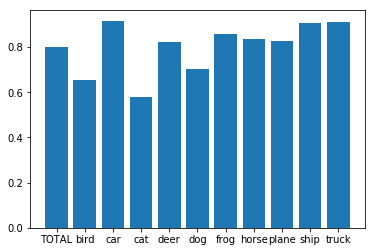

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = [class_correct[i]/class_total[i] for i in range(10)]
acc.append(correct/total)
xlabel = [classes[i] for i in range(10)]
xlabel.append('TOTAL')
plt.bar(xlabel, acc)

plt.show()